# Causal Machine Learning for Treatment Effect Estimation

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR

import torch
import torch.nn as nn
import torch.optim as optim

from auxiliary import data_processing, doubly_robust, visualise, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition, multicol
from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [13]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization.
EXPOSURE_THRESHOLD = 3

# set the period between observations. We only consider the effects between 60 and 120 days after exposure. 
PERIOD_MIN = 120
PERIOD_MAX = 240

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = True

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.6

# set to True if we want to undersample
UNDERSAMPLE = True #False #True

# set to True if we want to impute missing values
IMPUTE = True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True

TREATMENT = 'ig6a' # (hours of exc.)
OUTCOME = 'sADLSF' 

Having set the desired parameters, we will now read in the data.

In [14]:
file = "data/dutch_LTCF_all.csv"

# read data
df = pd.read_csv(file)
print(f"Treatment before processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

Treatment before processing 2919


## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [15]:
contra_indications = ['ij2e', 'ij2l', 'ij2n', 'ij2t', 'ij2q', 'ij2r', 'ij6b', 'ij6c',  'in6b', 'in6c'] 

#BIGGER THAN
value_based_contra_indications = {'ic1': [5], 'ij2e': [1],
                                 'ij2l': [1], 'ij2t': [1], 'ij2q': [1],
                                 'ij2r': [1]} 


# also convert values to list for ease of processing later on
#listed_val_based_ind = [key for key, value in value_based_contra_indications.items()]

contra_indications = contra_indications #+ listed_val_based_ind

confounders = ['il1', 'ij3', 'ij4', 'ij1', 'ij6c', 'sCPS', 'ig4', 'ig5']


# list covars that may be relevant but have not been listed elsewhere
other_relevant_covars = ['iA2', 'sAGE_cat', 'ia12a', 'ia13', 'ib5a', 'ib5b', 'ib5c', 'ic1', 'ic2c']

# list clinical indications
clinical_indications = ['sDRS', 'ij1', 'ij12', 'ij2a', 'ij2b', 'ij2c', 'ij2d']

# list of other relevant variables
relevant_vars = ['iA9', 'Clientid', TREATMENT, OUTCOME]

print(len(contra_indications))

10


In [16]:
print(encoding[('sDRS').lower()])

sDRS depression rating scale (0-14)


### 2.a. Indications

In [17]:
contras = lambda x: 1 if x >=1 else 0

# create indications column and set to 0
df['clin_indications'] = 0

# loop over all contra-indications
for contra in clinical_indications:
    # assign 1 to cases with contra-indication
    df['clin_indications'] = df[contra].apply(contras)

# only select patients with clinical indications
df = df[df['clin_indications']== 1]

### 2a. Contra-indications

Next, the first thing we want to do is to drop patients that have a contra-indication for the treatment in questions. In the code below, we specify the contra-indications. 

In [18]:
contras = lambda x: 1 if x >=1 else 0

# create indications column and set to 0
df['indications'] = 0

# loop over all contra-indications
for contra in contra_indications:
    # assign 1 to cases with contra-indication
    df['indications'] = df[contra].apply(contras)
    # drop cases
    df = df[df['indications']!= 1]

Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

In [19]:
# initialize empty tracker
# iterate over columns and corresponding values 
for key, value in value_based_contra_indications.items():    
    # loop over items in list
    for i in value:
        # drop values
        df = df[df[key]!=i]
        print(f'{i}-valued items from {encoding[key.lower()]} droped.')

5-valued items from Cognitive Skills for Daily Decision Making droped.
1-valued items from Chest pain droped.
1-valued items from Diarrhea droped.
1-valued items from Aspiration droped.
1-valued items from Fever Aspiration droped.
1-valued items from GI or GU bleeding droped.


Having processed the contra-indications, we can now select the necessary columns in the data.

In [20]:
df = df[clinical_indications+confounders + other_relevant_covars + relevant_vars + contra_indications]
print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

Treatment after selecting covariates 547


### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [21]:
# get number of assesments
counter = lambda x: len(df[df['Clientid']==x])

# count number of items
df['num_assesments'] = df['Clientid'].apply(counter)

Let us select only observations with more than 2 assesments. 

In [22]:
# get number of assesments higher than 1
df = df[df['num_assesments']>=2]

print(f'{len(df)} observations remaining.')
print(f"Treatment after selecting on number of assesments {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

10113 observations remaining.
Treatment after selecting on number of assesments 443


In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [23]:
# convert column to datetime 
df['iA9'] = pd.to_datetime(df['iA9']) 
# sort values by ID and date
df = df.sort_values(by = ['Clientid', 'iA9'])
# drop nans on dates of assesment
df = df[df['iA9'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [24]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('Clientid').apply(
    lambda x: x[x['iA9'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [25]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [26]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['Clientid'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['Clientid'] == client_id].sort_values('iA9')
        client_dates = client_rows['iA9'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['iA9'] == baseline_date]
            followup_row = client_rows[client_rows['iA9'] == followup_date]

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [27]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

889 of 889 items completed...
Completed.
Treatment after processing 315


### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [28]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
df['treatment'] = df[TREATMENT].apply(binary)  
df = df.drop(columns = [TREATMENT])

In [29]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])
df.head(3)

,sDRS,ij1,ij12,ij2a,ij2b,ij2c,ij2d,il1,ij3,ij4,...,ij2r,ij6b,in6b,in6c,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
0,3.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,8.0,7.0,2007-02-27,2007-05-02,1
1,3.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,7.0,7.0,2007-05-02,2009-03-14,1
2,5.0,2.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6,7.0,7.0,2009-03-14,2009-09-03,1


### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [30]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]

df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])
# examine how many treatment observations are left
len(df[df['treatment']==1])

355

### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [31]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=5)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [32]:
if REMOVE_MULTI_COL:
    df = multicol(df, CORRELATION_THRESHOLD)

### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [33]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

ij6c - End-stage disease, 6 or fewer months to live dropped.
ij2e - Chest pain dropped.
ij2l - Diarrhea dropped.
ij2n - Vomiting dropped.
ij2t - Aspiration dropped.
ij2q - Fever Aspiration dropped.
ij2r - GI or GU bleeding dropped.
ij6b - Experiencing an acute episode, or a flare-up of a recurrent or chronic problem dropped.
in6b - Unkown dropped.
in6c - Unkown dropped.


### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [34]:
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

In [35]:
# treatment = TREATMENT#'in3eb' # (minutes or days of physical therapy)
# target = #'sADLSF' 

#df = df.drop(columns = 'num_assesments')
df.to_csv(f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

Next, we want to select the models. Here we will use ``RandomForestRegressor()``.

In [36]:
model0 = RandomForestRegressor()
model1 = RandomForestRegressor()

Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [37]:
# call your data file here
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

Afterwards, we can run the model. The only thing to do is to run the ``run_model``-function below. 

In [38]:
metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c = run_model(file = FILE, model0 = model0, model1 = model1, undersampled = UNDERSAMPLE, machine = "RandomForest", num_iter = 1)

ValueError: Cannot take a larger sample than population when 'replace=False'

We can now examine the performance of the model by calling ``metrics``.

In [39]:
metrics

NameError: name 'metrics' is not defined

We can also visualise the model's *factual* predicted performance by calling the ``visualise`` function.

In [40]:
machine = "RandomForest"
visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

NameError: name 'predictions_t' is not defined

Also, if we want to visualize the ITES, we can run the following function (``visualise_ites``):

In [41]:
visualise_ites(ites_test, machine = machine, intervention = TREATMENT, target = OUTCOME)

NameError: name 'ites_test' is not defined

In [42]:
visualise_ites(ites_train, machine = machine, intervention = TREATMENT, target = OUTCOME)

NameError: name 'ites_train' is not defined

### 3.b Run More Models

In [43]:
# model_lst = [(RandomForestRegressor(),RandomForestRegressor()), (MLPRegressor(), MLPRegressor()), 
#             (GradientBoostingRegressor(), GradientBoostingRegressor()), (DecisionTreeRegressor(), DecisionTreeRegressor()),
#             (LinearRegression(), LinearRegression()), (Ridge(), Ridge()), (Lasso(), Lasso()),
#             (AdaBoostRegressor(), AdaBoostRegressor()), (ExtraTreesRegressor(), ExtraTreesRegressor()), 
#              (BaggingRegressor(), BaggingRegressor())]

# for model1, model2 in model_lst:
#     print(str(model1))
#     metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c = run_model(file = FILE, include_propensity = PROPENSITY, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1)
#     #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
#     visualise_ites(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
#     print(metrics)

## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

In [44]:
device = torch.device("cpu")

It is useful to have a small function that easily converts arrays to the correct ``torch``-objects: tensors.

In [45]:
to_tensor = lambda x: torch.tensor(np.array(x), dtype = torch.float32).to(device)

In [46]:
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"
df = pd.read_csv(FILE)

In [47]:
# apply min-max normalisation
X = df.drop(columns = ['treatment', 'OutcomeT1']).columns
df[X] = (df[X] - df[X].min()) / (df[X].max() - df[X].min())

### 4 a. Perform Undersampling Procedure

In [49]:
if UNDERSAMPLE:
    freq_treated = len(df[df['treatment']==0])
    control = df[df['treatment']==1].sample(freq_treated)
    treated = df[df['treatment']==0]
    df = pd.concat((control, treated))
    
print(f'DF lenght after undersampling: {len(df)}')

DF lenght after undersampling: 590


Because the model is a neural-network based architecture, it is usually helpful to apply min-max normalisation which converts the column values to \[0,1\] ranges.

### 4.b Train-Test Splitting

In the cell below, we perform train-test split. Note that we also split the train and test data into two groups: a control group and a treated group. Even though we do not explicItely use for train, it will be useful for the (sub-)group evaluation later on.

In [50]:
# variable setting for treatment
t = 'treatment'
# select the relevant outcome
y = "OutcomeT1" 
# specify test size
test_size = 0.2

# Split groups into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = [y]), df[['treatment', y]], test_size=test_size, random_state=42)

### 4.c Propensity Score Computation

In [51]:
# predict the propensity score
if PROPENSITY:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]
    X_test["OutcomeT1"] = y_test["OutcomeT1"]
    X = X_train.drop(columns = ['treatment']).columns
    X = X_test.drop(columns = ['treatment']).columns
    ps_model = LogisticRegression(C=1e2, max_iter=10000).fit(X_train[X], y_train['treatment'])
    X_train['ps'] = ps_model.predict_proba(X_train[X])[:, 1]
    X_test['ps'] = ps_model.predict_proba(X_test[X])[:, 1]
    
    # ensure that treatment is last column
    X_train['treatment_new'] =  X_train['treatment']
    X_train = X_train.drop(columns = ['treatment'])
    X_train = X_train.rename(columns = {'treatment_new': 'treatment'})
    
    X_test['treatment_new'] =  X_test['treatment']
    X_test = X_test.drop(columns = ['treatment'])
    X_test = X_test.rename(columns = {'treatment_new': 'treatment'})
    
    #X_train = X_train.drop(columns = ["OutcomeT1"])

In [52]:
X = df.drop(columns = ['OutcomeT1', 'treatment']).columns
#X_train = X_train.drop(columns = ["ps"])

# Estimate the average treatment effect (group level)
tau_est = doubly_robust(X_train, X=X, T='treatment', Y='OutcomeT1')
tau_est = torch.tensor(tau_est, dtype = torch.float32).to(device)
print(tau_est)

# drop columns
X_train = X_train.drop(columns = ["OutcomeT1"])
X_test = X_test.drop(columns = ["OutcomeT1"])

Estimated outcome under control 5.277192744890089.
Estimated outcome under treatment 4.850115108794926.
tensor(-0.4329)


We also want to make sure that the data stuctures are in the right format. For this, we use ``to_tensor``.

In [53]:
y_t = y_train[y_train['treatment']==1][y]
y_c = y_train[y_train['treatment']==0][y]

y_test_t = y_test[y_test['treatment']==1][y]
y_test_c = y_test[y_test['treatment']==0][y]

In [54]:
# convert output to tensors
x, y, y_t, y_c, x_test = to_tensor(X_train), to_tensor(y_train), to_tensor(y_t), to_tensor(y_c), to_tensor(X_test)

### 4.d Model Training

The next step is to train the actual model. The code below sets some preliminary configurations.

In [55]:
# Configurations
lr = 0.001
epochs = 1000
gamma = 2

model = TARnetICFR(x.shape[1], 0.01, hidden_dim = 32*4).to(device)

# Define the loss functions
head_loss = nn.L1Loss() #nn.MSELoss()#nn.L1Loss() #torch.nn.HuberLoss(reduction = 'mean', delta = 1) #nn.MSELoss() # nn.L1Loss() #nn.MSELoss() 

# initialise optimiser
optimizer = optim.Adam(model.parameters(), lr)

u = len(y_t)  / (len(y_t)  + len(y_c))

The code below is the training loop. On each loop, the model passes the data through the models, examines its performance and adjust the weights. Note that this model has four loss components:

1. Component 1 (``loss1``) is to loss on the treated segment of the data.
2. Component 2 (``loss2``) is to loss on the control segment of the data.
3. Component 2 (``loss_cf_3``) is to loss on the counterfactual control segment of the data.
4. Component 2 (``loss_cf_4``) is to loss on the counterfactual treated segment of the data.

In [56]:
# Define loss lists
loss1_lst, loss2_lst, loss3_lst = [], [], []

for epoch in range(epochs):
    # Forward pass
    output_t, output_c, _ = model(x)
    
    # Compute total loss and update the model's parameters
    loss1, loss2 = head_loss(torch.squeeze(output_t), y_t), head_loss(torch.squeeze(output_c), y_c)
    
    pred_c_cf = model.forward_treated(x[x[:,-1]==0])
    loss_cf_3 = (1 - u) * torch.mean((torch.squeeze(pred_c_cf) - (y_c + tau_est))**2)
                 
    pred_t_cf = model.forward_control(x[x[:,-1]==1])
    loss_cf_4 = u * torch.mean((torch.squeeze(pred_t_cf) - (y_t - tau_est))**2)
    
    # losses added
    loss = loss1 + (loss2) + loss_cf_3 + loss_cf_4 #+ (gamma * loss3)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10000 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}')
        
        # print intermediate results on test
        x_test_t = x_test[x_test[:,-1]==1] 
        x_test_c = x_test[x_test[:,-1]==0] 

        # # examine intermediate factual test performance
        y_t_pred = model.forward_treated(x_test_t).cpu().detach().numpy().reshape(len(x_test_t),)
        y_c_pred = model.forward_control(x_test_c).cpu().detach().numpy().reshape(len(x_test_c),)

        print(f"RMSE for factual treated {mean_squared_error(y_t_pred, y_test_t)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_t_pred, y_test_t)}") 
        print(f"RMSE for factual control {mean_squared_error(y_c_pred, y_test_c)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_c_pred, y_test_c)}") 

Epoch 100/1000 | Loss: 2.8461
RMSE for factual treated 1.1708815194415614
MAE for factual treated 0.714820206989176
RMSE for factual control 0.8877761559366496
MAE for factual treated 0.7278814090872711
Epoch 200/1000 | Loss: 2.3966
RMSE for factual treated 0.7573603327721774
MAE for factual treated 0.6098280254751444
RMSE for factual control 0.9185686212552908
MAE for factual treated 0.7028393160622075
Epoch 300/1000 | Loss: 2.1496
RMSE for factual treated 0.7425433113111268
MAE for factual treated 0.6111604522627133
RMSE for factual control 0.9528019480950835
MAE for factual treated 0.6537705006183319
Epoch 400/1000 | Loss: 1.7616
RMSE for factual treated 0.5664435140730623
MAE for factual treated 0.5927136415472397
RMSE for factual control 0.9014857811783755
MAE for factual treated 0.6217423431434721
Epoch 500/1000 | Loss: 1.6270
RMSE for factual treated 0.7065716285101958
MAE for factual treated 0.6180233164188954
RMSE for factual control 0.8677772199516597
MAE for factual treated 

### 4.e Model Evaluation
Having trained the model, we can no examine the performance on the test set. We first get the predictions for the treated and control groups. Then we visualise the predicted predicted vs. true values. 

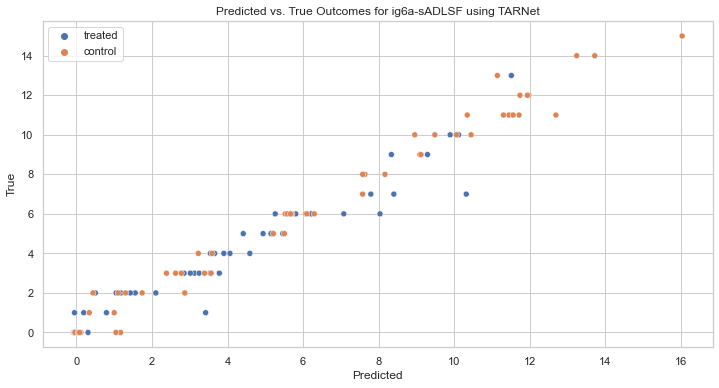

In [57]:
y_t_pred = model.forward_treated(x_test[x_test[:,-1]==1] ).cpu().detach().numpy()
y_c_pred = model.forward_control(x_test[x_test[:,-1]==0] ).cpu().detach().numpy()

machine = "TARNet"
visualise(np.squeeze(y_t_pred), np.squeeze(y_c_pred), y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Next, we want to estimate the model's predictions of the individual treatment effect. We plot this in an ordered fashion (from most beneficial to least beneficial). The blue dots depict patients. On the y-axis, we find the effect size as predicted by the model. 

ATE_est = 4.423308372497559 - 4.852082252502441 = -0.42877447605133057.


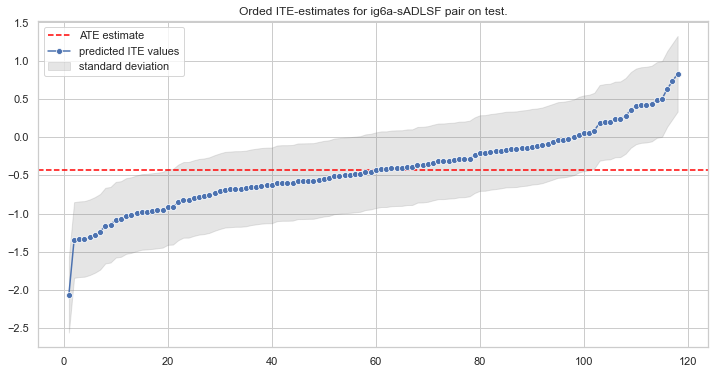

In [58]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()
y_t_predt1 = model.forward_treated(x_test_t).cpu().detach().numpy()
y_t_pred = np.concatenate((y_c_predt1, y_t_predt1))

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() #np.array(y_test_c).reshape(-1,1) #model.forward_control(x_test_c).cpu().detach().numpy()
y_t_predt0 = model.forward_control(x_test_t).cpu().detach().numpy()

y_c_pred = np.concatenate((y_c_predt0, y_t_predt0))

# compute the ites and sort
ites = y_t_pred - y_c_pred
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_t_pred - y_c_pred)

print(f"ATE_est = {np.mean(y_t_pred)} - {np.mean(y_c_pred)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE_est = 6.0750627517700195 - 6.495147705078125 = -0.4200848340988159.


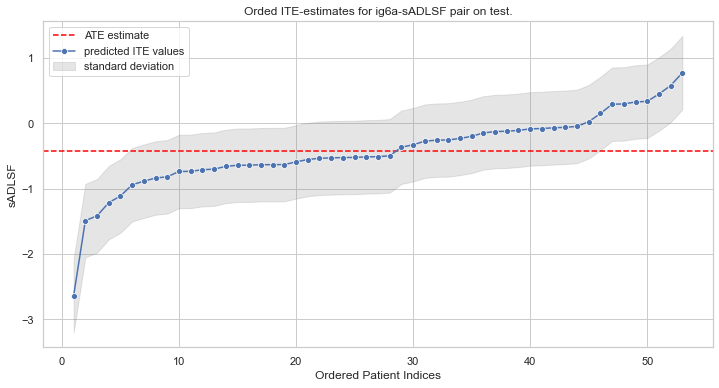

In [67]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() 

# compute the ites and sort
ites = y_c_predt1 - y_c_predt0
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_c_predt1 - y_c_predt0)

print(f"ATE_est = {np.mean(y_c_predt1)} - {np.mean(y_c_predt0)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

### 4.e Variable Importances

In [47]:
np.random.seed(42)

# Calculate the baseline performance
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Ensure no gradients are computed
    output_t, output_c, _ = model(x)
baseline_performance = mean_squared_error(output_t, y_t)
print(baseline_performance)

# Initialize a list to hold the feature importances
feature_importances = []
icodes = []
meanings = []
rank = []

collist = X_train.columns

# Calculate the importance for each feature
for i in range(x.shape[1]):  # Iterate over each feature
    # Save the original feature
    original_feature = x[:, i].clone()
    # Permute the feature
    permuted_feature = original_feature[torch.randperm(original_feature.size(0))]
    x[:, i] = permuted_feature
    
    # Calculate performance with the permuted data
    with torch.no_grad():
        output_t, output_c, _ = model(x)
        
    permuted_performance_t = mean_squared_error(output_t, y_t)
    permuted_performance_c = mean_squared_error(output_c, y_c)
    
    permuted_performance = permuted_performance_t + permuted_performance_t
    
    # Calculate the importance as the change in performance
    importance = baseline_performance - permuted_performance
    feature_importances.append(importance)
    
    # Restore the original feature
    x[:, i] = original_feature
    
# Rank the features by their importance
sorted_features = np.argsort(feature_importances)[::-1]  # Indices of features, sorted by importance

# Print the feature importances
print("Feature importances:")
for i, feature_index in enumerate(sorted_features):
    #print(f"Feature {feature_index}: Importance {feature_importances[feature_index]}")
    icode = collist[feature_index]
    icodes.append(icode.lower())
    
    try:
        item = encoding[icode.lower()]
        #print(item)
        meanings.append(item)
    except KeyError:
        #print(f'{icode} not found')
        meanings.append(f'{icode} not found')
    #print("==================================================")
    
rankings = pd.DataFrame(icodes, columns = ['icodes'])
rankings['meanings'] = meanings
rankings['importance_values'] = feature_importances

rankings = rankings.sort_values(by = 'importance_values')
rankings = rankings.reset_index().drop(columns = 'index')
rankings

0.065013096
Feature importances:


,icodes,meanings,importance_values
0,ps,ps not found,-67.763077
1,outcomet0,OutcomeT0 not found,-56.879513
2,treatment,treatment not found,-32.749352
3,ij2d,Unsteady gait,-10.009688
4,ij12,Recent falls,-4.764277
5,ij2b,Difficult or unable to turn self around and fa...,-3.466223
6,ih1,Bladder continence,-3.063635
7,id4a,Ability to see in adequate light (with glasses...,-2.809357
8,ij6a,"Conditions diseases make cognitive, ADL, mood,...",-1.504670
9,ie3e,"Resists care, taking medications, injections, ...",-1.449252


## Appendix 

In [48]:
# import numpy as np
# from scipy import stats


# ate = float(np.array(tau_est))

# # Assuming you have calculated the standard error of the ATE (SE_ATE)
# se_ate = np.std(ites)#2.0  # Replace with the actual standard error

# # Set your significance level (alpha)
# alpha = 0.05

# # Calculate the test statistic
# test_statistic = ate / se_ate

# # Calculate the p-value for a two-tailed test
# p_value = 2 * (1 - stats.norm.cdf(abs(test_statistic)))

# # Print the results
# print("ATE:", ate)
# print("Standard Error (SE_ATE):", se_ate)
# print("Test Statistic:", test_statistic)
# print("P-Value:", p_value)

# # Make a decision based on the p-value
# if p_value < alpha:
#     print("Reject the null hypothesis. There is a statistically significant causal effect.")
# else:
#     print("Fail to reject the null hypothesis. There is not enough evidence of a significant causal effect.")


In [49]:
# x_train_t = x[x[:,-1]==1] 
# x_train_c = x[x[:,-1]==0]
# # isolate and disconnect predicted values
# y_c_predt1 = model.forward_treated(x_train_c).cpu().detach().numpy()
# y_t_predt1 = model.forward_treated(x_train_t).cpu().detach().numpy()
# y_t_pred = np.concatenate((y_c_predt1, y_t_predt1))

# # isolate and disconnect predicted values
# y_c_predt0 = model.forward_control(x_train_c).cpu().detach().numpy()
# y_t_predt0 = model.forward_control(x_train_t).cpu().detach().numpy()

# y_c_pred = np.concatenate((y_c_predt0, y_t_predt0))

# # compute the ites and sort
# ites = y_t_pred - y_c_pred
# ites = [i[0] for i in ites]
# ites = sorted(list(ites))

# ate_model_est = np.mean(y_t_pred - y_c_pred)

# print(f"ATE_est = {np.mean(y_t_pred)} - {np.mean(y_c_pred)} = {ate_model_est}.")

# visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)